In [1]:
from functools import partial
import os
import pickle

from IPython.display import HTML, display
from matplotlib import pyplot as plt, rcParams
from matplotlib.animation import FuncAnimation
import numpy as np
from tqdm.notebook import tqdm

rcParams['animation.embed_limit'] = 1000
rcParams['axes.titlesize'] = 'xx-large'

VID_DIR = 'videos'

if not os.path.exists(VID_DIR):
    os.makedirs(VID_DIR)

# Setup - Complex periodic waveforms

In [2]:
def circle(N):
    """Complex sinusoid"""
    return np.exp(2j*np.pi * np.linspace(0, 1, N, endpoint=False))

def dots4(N):
    """Complex square wave"""
    sqw = np.array([1 + 1j, -1 + 1j, -1 - 1j, 1 - 1j])
    return sqw[np.linspace(0, 4, N, endpoint=False).astype(int)]

def diamond(N):
    """Complex triangle wave"""
    def triangle(phase):
        return 4 * np.abs(((np.linspace(0, 1, N, endpoint=False) + phase - 1/4) % 1) - 1/2) - 1
    return triangle(0.25) + 1j * triangle(0)

def epicycloid(N, R, r):
    t = np.linspace(0, 2*np.pi, N, endpoint=False)
    x = (R + r)*np.cos(t) - r*np.cos((R + r)/r * t)
    y = (R + r)*np.sin(t) - r*np.sin((R + r)/r * t)
    return x + 1j * y

def hypocycloid(N, R, r):
    t = np.linspace(0, 2*np.pi, N, endpoint=False)
    x = (R - r)*np.cos(t) + r*np.cos((R - r)/r * t)
    y = (R - r)*np.sin(t) - r*np.sin((R - r)/r * t)
    return x + 1j * y

def heart(N):
    t = -np.linspace(0, 2*np.pi, N, endpoint=False)
    x = 16 * np.sin(t) ** 3
    y = 13 * np.cos(t) - 5 * np.cos(2*t) - 2 * np.cos(3*t) - np.cos(4*t)
    return x + 1j * y

def butterfly(N):
    t = -np.linspace(0, 2*np.pi, N, endpoint=False)
    x = np.sin(t) * (np.exp(np.cos(t)) - 2*np.cos(4*t) - np.sin(t/12)**5)
    y = np.cos(t) * (np.exp(np.cos(t)) - 2*np.cos(4*t) - np.sin(t/12)**5)
    return x + 1j*y

# The following waveforms were obtained from bitmap images using the same technique I described in:
# https://gitlab.com/floofnoodlecode/badapple-fourier

def load_contour(filename, N):
    with open(filename, 'rb') as f:
        x = pickle.load(f).conjugate()
        x = np.append(x, x[0])
        x = np.interp(np.linspace(0, 1, N, endpoint=False), np.linspace(0, 1, len(x), endpoint=False), x)
        return x - x.mean()

def batman(N):
    return load_contour('batman.pkl', N)

def mandelbrot(N):
    return load_contour('mandelbrot.pkl', N)

def touhou(N):
    return load_contour('touhou.pkl', N)

In [3]:
def animate_wave(wave, res=150, fps=30, title=None, figsize=(6.4,5.4)):
    plt.ioff()
    fig, ax = plt.subplots(figsize=figsize)
    if title:
        plt.title(title)
    plt.tight_layout()
    
    tmp = np.append(wave, wave[0])
    plt.plot(tmp.real, tmp.imag, '-o')
    plt.grid()
    
    wave = np.interp(np.linspace(0, 1, res), np.linspace(0, 1, len(wave)), wave)
    dot, = plt.plot(wave[0].real, wave[0].imag, 'o', markersize=15)
    vln, = plt.plot([0, wave[0].real], [0, wave[0].imag], '-o', color='tab:red')
    plt.axis('equal')
    
    pbar = tqdm(total=len(wave), desc=title)
    def update(frame):
        pbar.update()
        if frame == len(wave) - 1:
            pbar.close()
        
        vln.set_data([0, wave[frame].real], [0, wave[frame].imag])
        dot.set_data(wave[frame].real, wave[frame].imag)
        return vln, dot
        
    anim = FuncAnimation(fig, update, frames=len(wave), interval=1000/fps, init_func=lambda:[])
    plt.close()
    plt.ion()
    return anim

In [5]:
%matplotlib notebook

# Show the waveforms
wave_funcs = [
    (circle, 'Sinusoid'),
    (dots4, 'Squarewave'),
    (partial(hypocycloid, R=3, r=1), 'Deltoid'),
    (heart, 'Heart'),
    (butterfly, 'Butterfly'),
    (batman, 'Batman'),
    (mandelbrot, 'Mandelbrot')
]

for f, title in wave_funcs + [(touhou, 'Touhou')]:
    anim = animate_wave(f(1024), title=title, figsize=(19.2, 10.8))
    anim.save(f'{VID_DIR}/wave_{title}.mp4')  # Save animation to disk.
    # Display animation in notebook. Commented because too many of these animations cause lag
#     display(HTML(anim.to_jshtml()))

Sinusoid:   0%|          | 0/150 [00:00<?, ?it/s]

Squarewave:   0%|          | 0/150 [00:00<?, ?it/s]

Deltoid:   0%|          | 0/150 [00:00<?, ?it/s]

Heart:   0%|          | 0/150 [00:00<?, ?it/s]

Butterfly:   0%|          | 0/150 [00:00<?, ?it/s]

Batman:   0%|          | 0/150 [00:00<?, ?it/s]

Mandelbrot:   0%|          | 0/150 [00:00<?, ?it/s]

Touhou:   0%|          | 0/150 [00:00<?, ?it/s]

# Fourier Transform with arbitrary basis

Let's say we have a signal $ x $ with samples $ x_0, \ldots, x_{N-1} \in \mathbb{C} $. The Discrete Time Fourier Transform (DTFT) finds coefficients $ X_k $ such that:
$$ x_n = \frac1N\sum_{k=0}^{N-1} X_k e^{i2\pi kn/N} \quad  n=0, \ldots, N-1 $$


We want to replace $ e^{i2\pi kn/N} $ with an arbitrary function $ y $ with samples $ y_0, \ldots, y_{N-1} \in \mathbb{C} $. Therefore, we now want to find $ X_k $ with the property: 
$$ x_n = \frac1N\sum_{k=0}^{N-1} X_k y_{(kn\bmod{N})} \quad  n=0, \ldots, N-1 $$

This can be written as a system of linear equations:
$$
\frac1N
\begin{bmatrix}
y_0 & y_0 & \cdots & y_0 & y_0 \\
y_0 & y_1 & \cdots & y_{N-2} & y_{N-1} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
y_0 & y_k & \cdots & y_{(k(N-2)\bmod N)} & y_{(k(N-1)\bmod N)} \\
\vdots & \vdots & \ddots & \vdots & \vdots \\
y_0 & y_{N-1} & \cdots & y_2 & y_1
\end{bmatrix}
\begin{bmatrix}
X_0\\
\vdots \\
\vdots \\
\vdots \\
X_{N-1}
\end{bmatrix}
=
\begin{bmatrix}
x_0\\
\vdots \\
\vdots \\
\vdots \\
x_{n-1}
\end{bmatrix}
$$

The system, written as $ \boldsymbol{x} = \frac1N A\boldsymbol{c} $ can then be solved by inverting the matrix: 
$ \boldsymbol{c}=NA^{-1}\boldsymbol{x} $
, assuming $ A $ is actually invertible, which is not true for arbitrary functions $ y $.

## Setup some functions

In [6]:
def harmonic(y, k):
    """Helper function to return signal `y` sampled with frequency `k`"""
    N = len(y)
    return y[np.arange(N) * k % N]

def dtft(x, y):
    """
    Compute the frequency coefficients
    
    :param x: Signal `x` to decompose
    :param y: Basis signal `y`
    :return: Coefficients `c`
    """
    y = y / len(y)
    A = np.stack([harmonic(y, k) for k in range(len(y))])
    return np.linalg.solve(A, x)

def idtft(c, y):
    """
    Restore signal from frequency coefficients.
    Returns the cumulative sum with coefficients sorted by amplitude and excluding the DC component.
    Useful for animations.
    
    :param c: Coefficients
    :param y: Base signal `y` used to decompose `x`
    :return: ndarray of size (N, N) where each i-th row is computed using the highest i coefficients
    """    
    N = len(y)
    cidxs = np.argsort(np.abs(c[1:]))[::-1] + 1
    ix = np.cumsum([c[0] * harmonic(y,0)] + [c[k] * harmonic(y, k) for k in cidxs], axis=0)
    ix = ix[1:] / N
    return ix, cidxs

## Sanity check
If $ y = e^{i2\pi kn/N} $ then the coefficients should be equal to the ones obtained by the DTFT.

Text(0.5, 1.0, 'Error = 8e-10. Close enough')

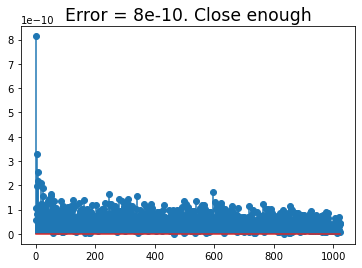

In [7]:
%matplotlib inline

N = 1024
x = touhou(N)
X = np.fft.fft(x)

y = circle(N)
c = dtft(x, y)

plt.stem(np.abs(c - X))
plt.title('Error = 8e-10. Close enough')

## Not all waveforms produce an invertible matrix
For the butterfly waveform, $ \det A \approx 0 $, so this waveform doesn't work. We can see that the coefficients have high values all accross the spectrum.

Unfortunately, I don't know of a way to tell at a glance whether a waveform will produce an invertible matrix or not. 
* My intuition is that it has something to do with how many times the function rotates around the origin, which is why I picked the other signals to only make one revolution. 
* I also know that the average of the samples should be 0 (this one I can prove). 

If you know the answer to this, along with a nice proof, please let me know.

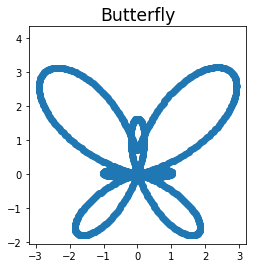

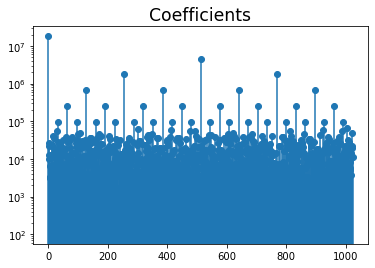

det(A) = 0j


In [8]:
y = butterfly(N)

plt.plot(y.real, y.imag, '-o')
plt.axis('square')
plt.title('Butterfly')
plt.show()

c = dtft(x, y)
plt.figure()
plt.stem(np.abs(c))
plt.yscale('log')
plt.title('Coefficients')
plt.show()

# Check the matrix determinant
A = np.stack([harmonic(y / len(y), k) for k in range(len(y))])
print('det(A) =', np.linalg.det(A))

# Let's see how the signal changes as we add more frequencies 

In [9]:
def animate_progression(ix, fps=30, title=None, figsize=(6.4,5.4)):
    plt.ioff()
    fig, ax = plt.subplots(figsize=figsize)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.axis('equal')
    plt.tight_layout()
    
    ix = np.append(ix, ix[:,0,None], axis=1)
    N = len(ix)
    pbar = tqdm(total=N, desc=title)
    
    ln, = plt.plot([ix.real.min(), ix.real.max()], [ix.imag.min(), ix.imag.max()], '-o')

    def update(i):
        ln.set_data(ix[i].real, ix[i].imag)
        
        pbar.update()
        if i == N-1:
            pbar.close()
        return [ln]

    anim = FuncAnimation(fig, update, frames=len(ix), interval=1000/fps, init_func=lambda:[])
    plt.close()
    plt.ion()
    return anim

## Reconstructing a complex signal

In [10]:
%matplotlib notebook

N = 1024
x = touhou(N)
for wavef, title in wave_funcs:   
    y = wavef(N)
    c = dtft(x, y)
    ix, _ = idtft(c, y)
    anim = animate_progression(ix, title=title)
    anim.save(f'{VID_DIR}/progression_{title}.mp4')  # Save animation to disk.
    # Display animation in notebook. Commented because too many of these animations cause lag
#     display(HTML(anim.to_jshtml()))

Sinusoid:   0%|          | 0/1023 [00:00<?, ?it/s]

Squarewave:   0%|          | 0/1023 [00:00<?, ?it/s]

Deltoid:   0%|          | 0/1023 [00:00<?, ?it/s]

Heart:   0%|          | 0/1023 [00:00<?, ?it/s]

Butterfly:   0%|          | 0/1023 [00:00<?, ?it/s]

Batman:   0%|          | 0/1023 [00:00<?, ?it/s]

Mandelbrot:   0%|          | 0/1023 [00:00<?, ?it/s]

# Animate components

In [11]:
def animate_components(ix, y, c, cidxs, Nfreq, fps=30, title=None, zoom=None, figsize=(6.4,5.4)):
    plt.ioff()
    fig, ax = plt.subplots(figsize=figsize)
    if title or True:
        plt.title(title)
    plt.axis('off')
    plt.axis('equal')
    plt.tight_layout()
    
    N = len(c)
    c /= N
    ys = np.array([harmonic(y, k) * c[k] for k in range(N)])
    ys = np.append(ys, ys[:,0,None], axis=1)
    ix = np.append(ix, ix[:,0,None], axis=1)
    ix = np.insert(ix, 0, ys[0], axis=0)
    cidxs = np.insert(cidxs, 0, 0)
    
    ln, = plt.plot(ix[Nfreq].real, ix[Nfreq].imag, '-o')
    dot, = plt.plot([ix.real.min(), ix.real.max()], [ix.imag.min(), ix.imag.max()], 'o', markersize=15, zorder=2.1)
    
    glns = []
    for i in range(1, Nfreq+1):
        y = ys[cidxs[i]] + ix[i-1, 0]
        gln, = plt.plot(y.real, y.imag, color='tab:green')
        glns.append(gln)
        
    vln, = plt.plot(ix[:Nfreq+1, 0].real, ix[:Nfreq+1, 0].imag, '-o', color='tab:red', zorder=2.2)
    
    if zoom is not None:
        xmin, xmax, ymin, ymax = plt.axis()
        xr = (xmax - xmin) / 2 / zoom
        yr = (ymax - ymin) / 2 / zoom
        
    pbar = tqdm(total=N, desc=title)
    def update(i):
        pbar.update()
        if i == N-1:
            pbar.close()
            
        dot.set_data(ix[Nfreq,i].real, ix[Nfreq,i].imag)
        for j in range(1, Nfreq+1):
            y = ys[cidxs[j]] + ix[j-1,i]
            glns[j-1].set_data(y.real, y.imag)
            
        vln.set_data(ix[:Nfreq+1, i].real, ix[:Nfreq+1, i].imag)
        
        if zoom is not None:
            c = ix[Nfreq, i]
            ax.set_xlim(c.real - xr, c.real + xr)
            ax.set_ylim(c.imag - yr, c.imag + yr)
        
        return dot, glns, vln
    
    anim = FuncAnimation(fig, update, frames=N, interval=1000/fps, init_func=lambda:[])
    plt.close()
    plt.ion()
    return anim

## Drawing with circles (the normal Fourier Transform)

In [13]:
%matplotlib notebook

N = 1024
FREQS = 10
y = circle(N)
for wavef, title in wave_funcs: 
    x = wavef(N)
    c = dtft(x, y)
    ix, cidxs = idtft(c, y)
    anim = animate_components(ix, y, c, cidxs, FREQS, title=title)
    anim.save(f'{VID_DIR}/circle_components={FREQS}_{title}.mp4')  # Save animation to disk.
    # Display animation in notebook. Commented because too many of these animations cause lag
#     display(HTML(anim.to_jshtml()))

Sinusoid:   0%|          | 0/1024 [00:00<?, ?it/s]

Squarewave:   0%|          | 0/1024 [00:00<?, ?it/s]

Deltoid:   0%|          | 0/1024 [00:00<?, ?it/s]

Heart:   0%|          | 0/1024 [00:00<?, ?it/s]

Butterfly:   0%|          | 0/1024 [00:00<?, ?it/s]

Batman:   0%|          | 0/1024 [00:00<?, ?it/s]

Mandelbrot:   0%|          | 0/1024 [00:00<?, ?it/s]

## Drawing a circle

In [14]:
N = 1024
FREQS = 10
x = circle(N)
for wavef, title in wave_funcs:
    y = wavef(N)
    c = dtft(x, y)
    ix, cidxs = idtft(c, y)
    anim = animate_components(ix, y, c, cidxs, FREQS, title=title)
    anim.save(f'{VID_DIR}/components={FREQS}_circle_{title}.mp4')  # Save animation to disk.
    # Display animation in notebook. Commented because too many of these animations cause lag
#     display(HTML(anim.to_jshtml()))

Sinusoid:   0%|          | 0/1024 [00:00<?, ?it/s]

Squarewave:   0%|          | 0/1024 [00:00<?, ?it/s]

Deltoid:   0%|          | 0/1024 [00:00<?, ?it/s]

Heart:   0%|          | 0/1024 [00:00<?, ?it/s]

Butterfly:   0%|          | 0/1024 [00:00<?, ?it/s]

Batman:   0%|          | 0/1024 [00:00<?, ?it/s]

Mandelbrot:   0%|          | 0/1024 [00:00<?, ?it/s]

## Drawing a complex function

In [15]:
N = 1024
FREQS = 50
x = touhou(N)
for wavef, title in wave_funcs:   
    y = wavef(N)
    c = dtft(x, y)
    ix, cidxs = idtft(c, y)
    anim = animate_components(ix, y, c, cidxs, FREQS, title=title)
    anim.save(f'{VID_DIR}/components={FREQS}_touhou_{title}.mp4')  # Save animation to disk.
    # Display animation in notebook. Commented because too many of these animations cause lag
#     display(HTML(anim.to_jshtml()))

Sinusoid:   0%|          | 0/1024 [00:00<?, ?it/s]

Squarewave:   0%|          | 0/1024 [00:00<?, ?it/s]

Deltoid:   0%|          | 0/1024 [00:00<?, ?it/s]

Heart:   0%|          | 0/1024 [00:00<?, ?it/s]

Butterfly:   0%|          | 0/1024 [00:00<?, ?it/s]

Batman:   0%|          | 0/1024 [00:00<?, ?it/s]

Mandelbrot:   0%|          | 0/1024 [00:00<?, ?it/s]